In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)
sns.set_palette('tab10')
sns.set_style('white')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv('../krajbich_PNAS_2011/data.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.set_index(['subject', 'trial'], inplace=True)
df.rename(columns={
    'roirating': 'roi_rating',
    'leftroi': 'roi1',
    'middleroi': 'roi2',
    'rightroi': 'roi3'
}, inplace=True)
trial_ratings = df.groupby(['subject', 'trial'])[[f'rating{i}' for i in range(1,4)]].mean()

df['mean_rating'] = trial_ratings.mean(1)
df['min_rating'] = trial_ratings.min(1)
df['norm_roi_rating'] = df.roi_rating - df.mean_rating

In [3]:
roi = df[['roi1', 'roi2', 'roi3']].as_matrix()
df['roi'] = (roi * [1,2,3]).sum(1)
choice = df[['choice1', 'choice2', 'choice3']].as_matrix()
df['choice'] = (choice * [1,2,3]).sum(1)
rank = df[['rating1', 'rating2', 'rating3']].rank(1, ascending=False).astype(int).as_matrix()
roi_rank = (roi * rank).sum(1)
df['roi_rank'] = roi_rank

/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [13]:
def pull_values(row, key):
    x = row[[f'{key}{i}' for i in (1,2,3)]].copy()
    x.index = [1,2,3]
    return x

def others(i):
    return {1,2,3} - {i}

In [14]:
trial = df.loc[1, 1]
def parse_trial(trial):
    last = trial.iloc[-1].astype(int)
    rating = pull_values(last, 'rating')
    fixtime = trial.groupby('roi').eventduration.sum()
    t = {
        'rt': last.rt,
        'subject': last.subject,
        'trial': last.trial,
        'last_fix': last.roi,
        'choice': last.choice,
        'last_duration': last.eventduration,
        'choose_last': last.choice == last.roi,
        'last_fix_value_advantage': rating[last.roi] - rating[others(last.roi)].mean()
#         'last_value': last[f'rating{last.roi}']
    }
#     for i in range(1,4):
#         t[f'rating{i}'] = last[f'rating{i}']
#         t[f'fixtime{i}'] = fixtime.get(i, 0)
    return t

tdf = pd.DataFrame(list(df.reset_index().groupby(['subject', 'trial']).apply(parse_trial)))

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


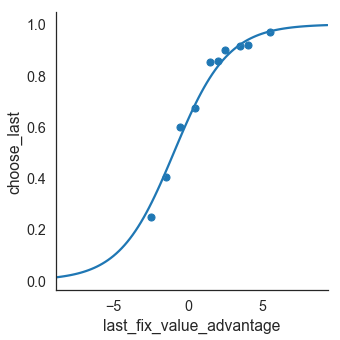

In [15]:
sns.lmplot('last_fix_value_advantage', 'choose_last', x_bins=10, ci=False, logistic=True, data=tdf)

In [8]:
def softmax(x, temp=1, np=np):
    ex = np.exp((x - x.max(-1, keepdims=True)) / temp)
    return ex / ex.sum(-1, keepdims=True)

trial = df.loc[1, 1]
softmax(trial.iloc[0][['rating1', 'rating2', 'rating3']].as_matrix())

/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([0.00242826, 0.97962921, 0.01794253])

In [11]:
def long_form(df, quant=50):
    for (sub, t), trial in df.reset_index().groupby(['subject', 'trial']):
        step = 0
        for _, fix in (trial.iterrows()):
            for _ in range(int(round(fix.eventduration / quant))):
                x = fix[['subject', 'trial', 'roi', 'roi_rating', 'roi_rank']]
                x['step'] = step
                step += quant
                yield x

ldf = pd.DataFrame(long_form(df.reset_index().query('rt < 5000')))

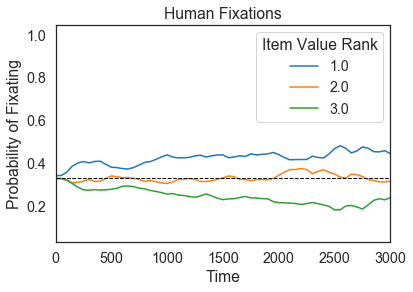

In [264]:
n_step = ldf.groupby(['roi_rank', 'step']).apply(len)
p_step = n_step / n_step.sum(level=1)
p_step.unstack().T.plot()
plt.xlim(1,3000)
plt.ylabel('Probability of Fixating')
plt.xlabel('Time')
plt.legend(title='Item Value Rank')
plt.axhline(1/3, c='k', lw=1, ls='--')
plt.title('Human Fixations');
plt.savefig('figs/human_fix.pdf')

# Model

In [4]:
from glob import glob
from joblib import load
results = [load(file) for file in glob('pickles/sims/*')]

In [5]:
from scipy.stats import rankdata

def focus_rank(trace):
    ranks = rankdata(-trace['true_mu'])
    for i, rank in enumerate(ranks[np.array(trace['focused'])]):
        yield {'step': i, 'rank': rank}


def load_ranks(traces):
    for t in traces:
        yield from focus_rank(t) 

## Figures from Krajbich PNAS 

In [6]:
def parse_trace(trace):
    value = trace['true_mu']
    chosen = np.argmax(trace['mu'][-1])
    focused = trace['focused']
    last = focused[-1]
    fixcounts = pd.Series(focused).value_counts()
    return {
        'last_advantage': value[last] - (value.sum() - value[last]) / 2,
        'n_step': len(focused),
        'switchiness': (np.diff(focused) != 0).sum() / len(focused),
        'choose_last': chosen == last,
        'choose_0': chosen == 0,
        '0_fix_adv': 2 * fixcounts.get(0, 0)  - fixcounts.sum()
        
    }

def parse_traces():
    for r in results:
        for t in r['traces']:
            yield {**r['params'], **parse_trace(t)}
mdf = pd.DataFrame(parse_traces())

In [7]:
VARS = ['obs_sigma', 'sample_cost', 'switch_cost']
mdf.groupby(['obs_sigma', 'sample_cost']).n_step.mean()

obs_sigma  sample_cost
1          0.001          31.391667
           0.005          21.250000
           0.010           8.697333
3          0.001          77.549000
           0.005          34.196333
           0.010          17.427667
5          0.001          68.082333
           0.005          23.223333
           0.010          17.771000
Name: n_step, dtype: float64

## 3A

In [8]:
traces = load('pickles/sims/3_5_0.005_0.005')['traces']

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


FileNotFoundError: [Errno 2] No such file or directory: 'figs/3a.png'

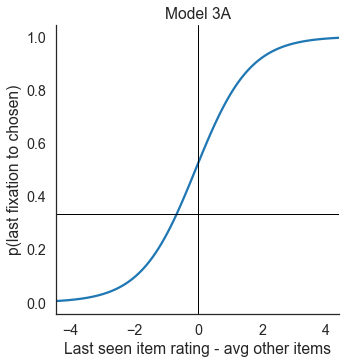

In [9]:
dd = mdf.set_index(VARS).loc[5, 0.001, 0.005]
g = sns.lmplot('last_advantage', 'choose_last', data=dd,
                logistic=True, ci=False, scatter=False)
plt.axhline(1/3, c='k', lw=1)
plt.axvline(0, c='k', lw=1)
plt.xlabel('Last seen item rating - avg other items')
plt.ylabel('p(last fixation to chosen)')
plt.title('Model 3A')
plt.savefig('figs/3a.png')

## 3C

In [ ]:
dd = mdf.set_index(VARS).loc[5, 0.005, 0.005]
dd['bin0_fix_adv'] = pd.cut(dd['0_fix_adv'], np.arange(-3.5, 4.5, 1)).apply(lambda x: x.mid)
g = sns.barplot('bin0_fix_adv', 'choose_0', data=dd, ci=False, color='C0')
# plt.axhline(1/3, c='k', lw=1)
# plt.axvline(0, c='k', lw=1)
plt.xlabel('Final time advantage left')
plt.ylabel('p(left choosen)')
plt.title('Model 3C')
plt.savefig('figs/3c.png')

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


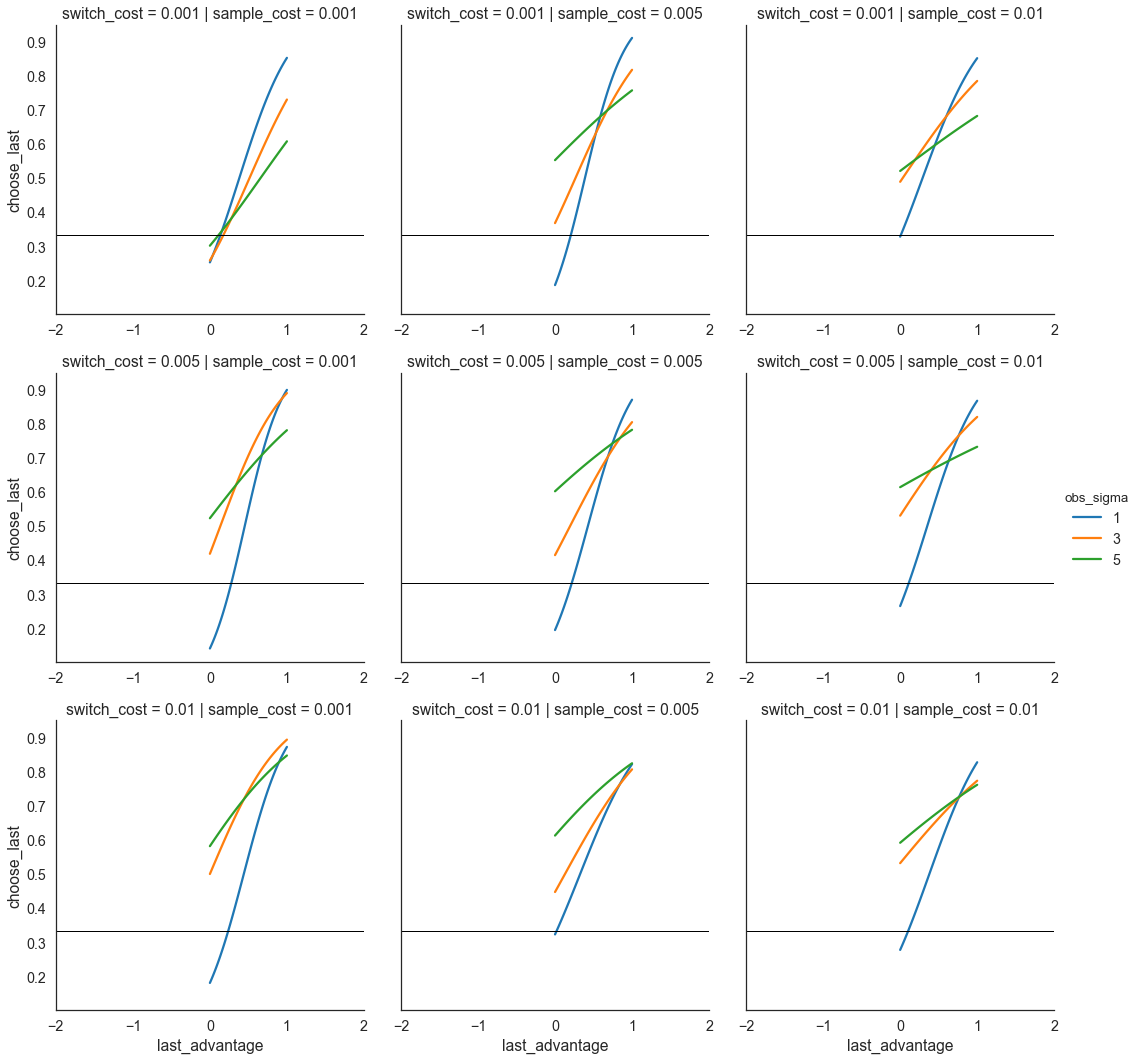

In [172]:

g = sns.lmplot('last_advantage', 'choose_last', data=df, sharex=False,
           hue='obs_sigma', col='sample_cost', row='switch_cost',
           logistic=True, ci=False, scatter=False)
for ax in g.axes.flat:
    plt.sca(ax)
    ax.axhline(1/3, c='k', lw=1)
    plt.xlim(-2, 2)
    
# plt.axvline(0, c='k')

# Model fixations

In [ ]:
ranks = pd.DataFrame(load_ranks(traces))
n_step = ranks.groupby(['rank', 'step']).apply(len)
p_step = n_step / n_step.sum(level=1)
p_step.unstack().T.plot()
plt.xlim(0, (n_step.sum(level='step') < 100).argmax())
plt.title('Model Fixations')
plt.xlabel('Time')
plt.ylabel('Probability of Fixating')
plt.savefig('figs/model_fix.pdf')

## All conditions

In [14]:
from joblib import load
import sys
sys.path.append('../python')
import metabandits
pol = load('../python/pickles/policies/3_3_0.001_0.005')
pol.theta
# policies

array([0.   , 0.828, 0.   , 0.172])

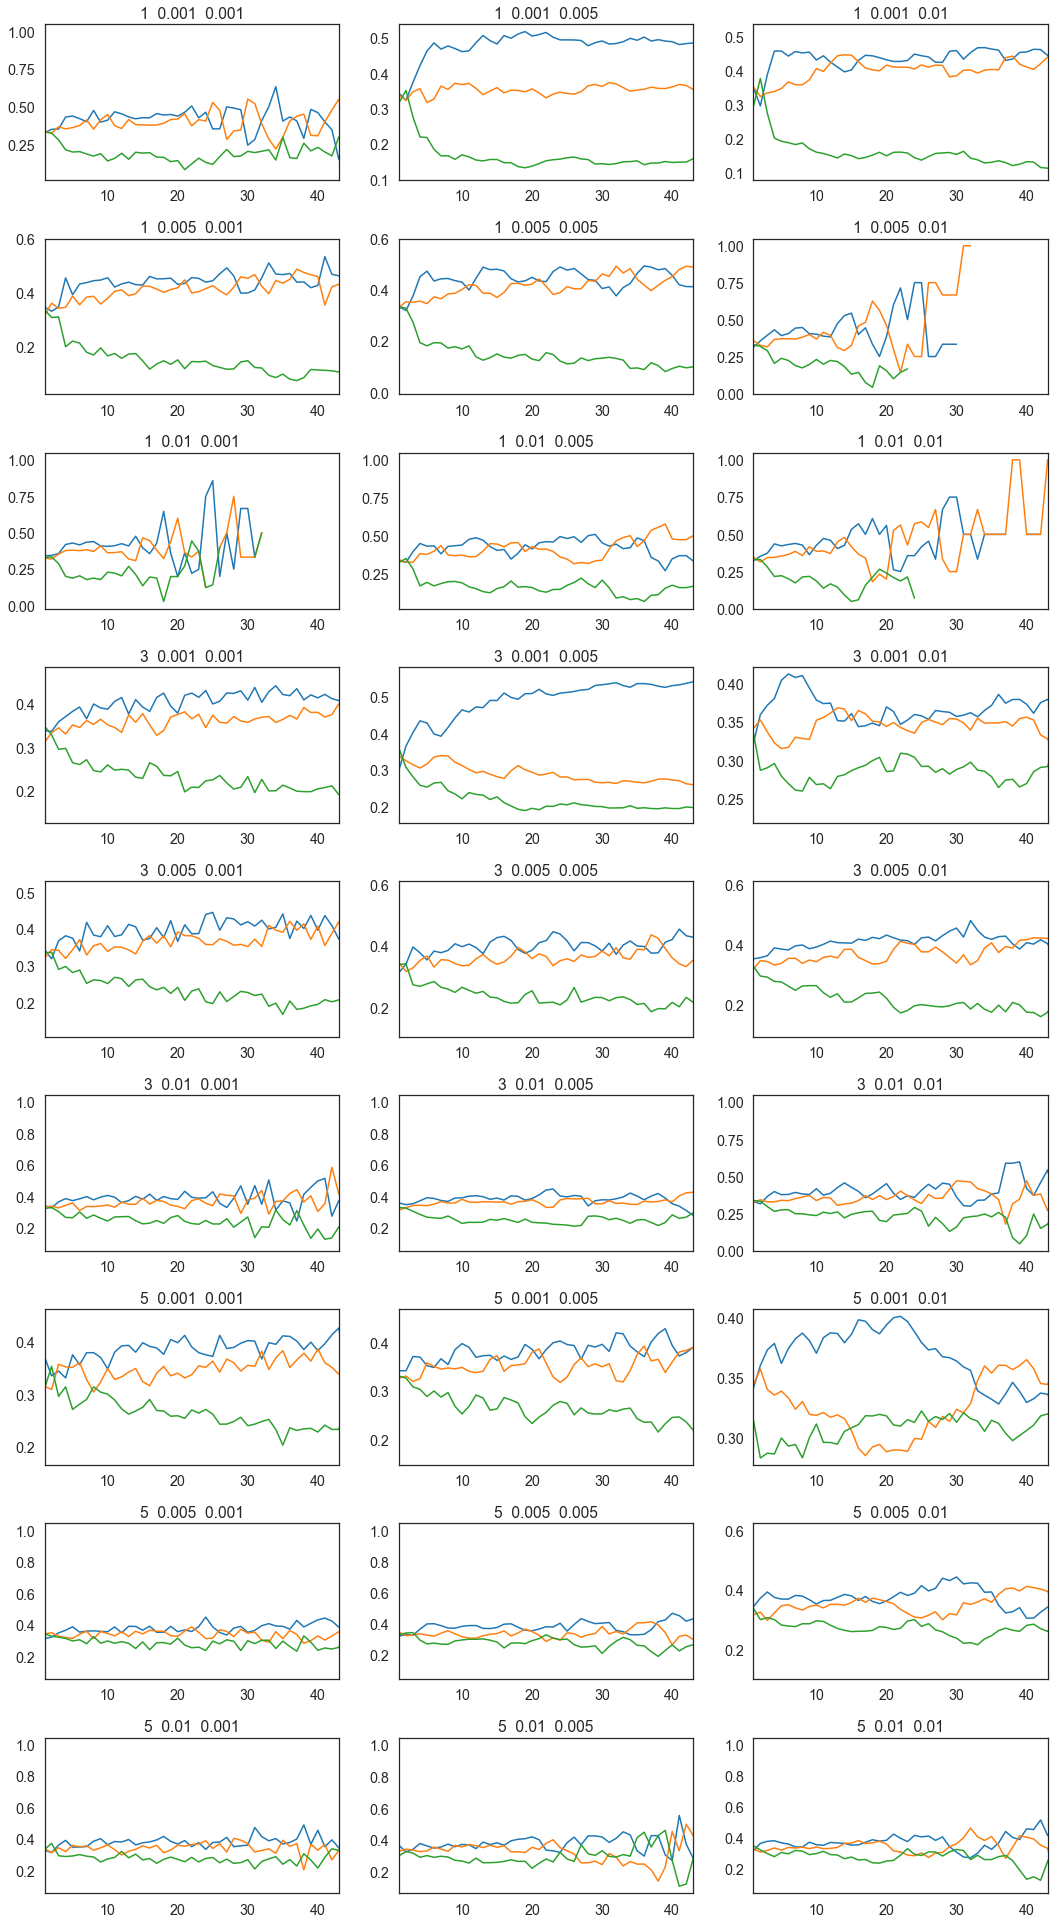

In [106]:
files = glob('pickles/sims/*')
fig, axes = plt.subplots(9, 3, figsize=(15, 27))
for (params, df), ax in zip(frames, axes.flat):
    plt.sca(ax)
    df.unstack().T.plot(ax=ax, legend=False)
    plt.xlim(1, max_step)
    plt.xlabel('')
    plt.ylabel('')
#     plt.ylabel('p(focus)')
#     plt.legend(title='Item Value Rank');
    plt.title('{obs_sigma}  {sample_cost}  {switch_cost}'.format_map(params))
plt.tight_layout()

In [ ]:
## Misc
n_fix = df.groupby(['roi_rank', 'fix_num']).apply(len)
p_fix = n_fix / n_fix.sum(level=1)
p_fix.unstack().T.plot()
plt.xlim(1,7)
plt.xlabel('Fixation Number')
plt.ylabel('Probability of Fixating')
plt.legend(title='Item Value Rank');
plt.axhline(1/3, c='k', lw=1, ls='--')